# BatchNorm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(42)

batch_size = 64
n_features = 100

In [3]:
x = torch.zeros(batch_size, n_features)
for i in range(n_features):
    # each feature has a different scale
    scale = np.random.uniform(0.1, 10)
    mean = np.random.uniform(-5, 5)
    x[:, i] = torch.normal(mean=mean, std=scale, size=(batch_size,))

print("Original data stats:")
print(f"Mean: {x.mean().item():.4f}")
print(f"Std: {x.std().item():.4f}")
print(f"Min: {x.min().item():.4f}")
print(f"Max: {x.max().item():.4f}")

Original data stats:
Mean: 0.1166
Std: 6.9644
Min: -33.0509
Max: 33.6686


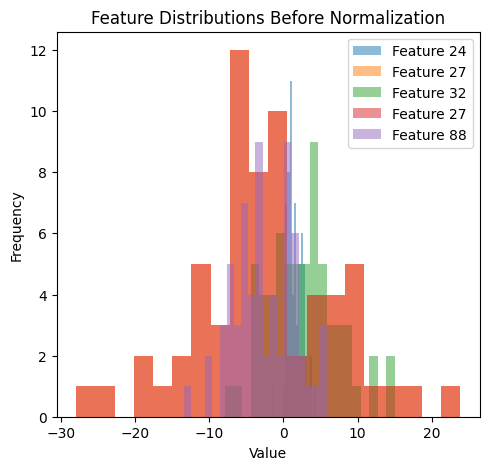

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(5):
    feature_idx = np.random.randint(0, n_features)
    plt.hist(x[:, feature_idx].numpy(), alpha=0.5, bins=20, label=f'Feature {feature_idx}')
plt.title('Feature Distributions Before Normalization')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

In [5]:
def batch_norm(x, gamma=None, beta=None, eps=1e-5):
    """
    batch normalization on input tensor x
    
    Args:
        x: Input tensor of shape (batch_size, n_features)
        gamma: Scaling parameter of shape (n_features,)
        beta: Shifting parameter of shape (n_features,)
        eps: Small constant for numerical stability
    
    Returns:
        normalized_x: Normalized tensor
        batch_mean: Mean of each feature across the batch
        batch_var: Variance of each feature across the batch
    """
    # calculate mean across the batch for each feature
    batch_mean = torch.mean(x, dim=0)

    # calculate variance across the batch for each feature
    batch_var = torch.var(x, dim=0, unbiased=False)

    # normalize the input
    x_centered = x - batch_mean  # center around 0
    x_normalized = x_centered / torch.sqrt(batch_var + eps)  # scale to unit variance

    # apply scale and shift (if provided)
    if gamma is not None and beta is not None:
        out = gamma * x_normalized + beta
    else:
        out = x_normalized
        
    return out, batch_mean, batch_var


In [6]:
# initially, we'll set gamma=1 and beta=0, which means no scaling or shifting
gamma = torch.ones(n_features, requires_grad=True)
beta = torch.zeros(n_features, requires_grad=True)

x_normalized, batch_mean, batch_var = batch_norm(x, gamma, beta)

print("\nNormalized data stats:")
print(f"Mean: {x_normalized.mean().item():.4f}")
print(f"Std: {x_normalized.std().item():.4f}")
print(f"Min: {x_normalized.min().item():.4f}")
print(f"Max: {x_normalized.max().item():.4f}")


Normalized data stats:
Mean: 0.0000
Std: 1.0001
Min: -3.9088
Max: 3.3844


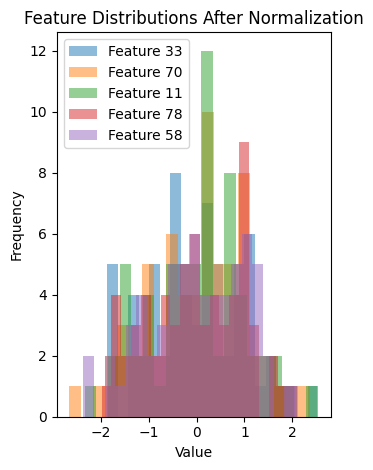

In [7]:
plt.subplot(1, 2, 2)
for i in range(5):
    feature_idx = np.random.randint(0, n_features)
    plt.hist(x_normalized[:, feature_idx].detach().numpy(), alpha=0.5, bins=20, label=f'Feature {feature_idx}')
plt.title('Feature Distributions After Normalization')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('normalization_comparison.png')

# Models

In [8]:
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:07<00:00, 1.41MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 224kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
    batch_size=100,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
    batch_size=100,
    shuffle=False
)

In [11]:
# model WITHOUT batch normalization
class NetWithoutBN(nn.Module):
    def __init__(self):
        super(NetWithoutBN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
class NetWithBN(nn.Module):
    def __init__(self):
        super(NetWithBN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.bn1(self.fc1(x)))  # Apply BN after linear and before ReLU
        x = self.relu(self.bn2(self.fc2(x)))  # Apply BN after linear and before ReLU
        x = self.fc3(x)
        return x

In [13]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                losses.append(loss.item())
                
    return losses

In [14]:
def evaluate(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [20]:
def get_bn_parameters(model):
    gammas = []
    betas = []
    for module in model.modules():
        if isinstance(module, nn.BatchNorm1d):
            # get gamma (weight) and beta (bias)
            gammas.append(module.weight.detach().cpu().numpy())
            betas.append(module.bias.detach().cpu().numpy())
    return gammas, betas

# Tests

In [15]:
# experiment 1: train model without batch normalization
model_without_bn = NetWithoutBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_without_bn = optim.SGD(model_without_bn.parameters(), lr=0.01, momentum=0.9)

print("Training model WITHOUT batch normalization...")
losses_without_bn = train(model_without_bn, train_loader, criterion, optimizer_without_bn)
accuracy_without_bn = evaluate(model_without_bn, test_loader)

Training model WITHOUT batch normalization...
Epoch [1/5], Step [100/600], Loss: 0.4550
Epoch [1/5], Step [200/600], Loss: 0.2317
Epoch [1/5], Step [300/600], Loss: 0.2716
Epoch [1/5], Step [400/600], Loss: 0.3004
Epoch [1/5], Step [500/600], Loss: 0.2147
Epoch [1/5], Step [600/600], Loss: 0.2845
Epoch [2/5], Step [100/600], Loss: 0.1154
Epoch [2/5], Step [200/600], Loss: 0.2192
Epoch [2/5], Step [300/600], Loss: 0.1650
Epoch [2/5], Step [400/600], Loss: 0.1323
Epoch [2/5], Step [500/600], Loss: 0.0636
Epoch [2/5], Step [600/600], Loss: 0.0814
Epoch [3/5], Step [100/600], Loss: 0.1157
Epoch [3/5], Step [200/600], Loss: 0.0918
Epoch [3/5], Step [300/600], Loss: 0.0353
Epoch [3/5], Step [400/600], Loss: 0.0637
Epoch [3/5], Step [500/600], Loss: 0.0481
Epoch [3/5], Step [600/600], Loss: 0.1477
Epoch [4/5], Step [100/600], Loss: 0.1024
Epoch [4/5], Step [200/600], Loss: 0.0661
Epoch [4/5], Step [300/600], Loss: 0.1031
Epoch [4/5], Step [400/600], Loss: 0.1462
Epoch [4/5], Step [500/600], L

In [22]:
# experiment 2: train model with batch normalization
model_with_bn = NetWithBN().to(device)
before_gammas, before_betas = get_bn_parameters(model_with_bn)
criterion = nn.CrossEntropyLoss()
optimizer_with_bn = optim.SGD(model_with_bn.parameters(), lr=0.01, momentum=0.9)

print("Training model WITH batch normalization...")
losses_with_bn = train(model_with_bn, train_loader, criterion, optimizer_with_bn)
after_gammas, after_betas = get_bn_parameters(model_with_bn)
accuracy_with_bn = evaluate(model_with_bn, test_loader)

Training model WITH batch normalization...
Epoch [1/5], Step [100/600], Loss: 0.3090
Epoch [1/5], Step [200/600], Loss: 0.2573
Epoch [1/5], Step [300/600], Loss: 0.1913
Epoch [1/5], Step [400/600], Loss: 0.1406
Epoch [1/5], Step [500/600], Loss: 0.1159
Epoch [1/5], Step [600/600], Loss: 0.1791
Epoch [2/5], Step [100/600], Loss: 0.0918
Epoch [2/5], Step [200/600], Loss: 0.1160
Epoch [2/5], Step [300/600], Loss: 0.0978
Epoch [2/5], Step [400/600], Loss: 0.0768
Epoch [2/5], Step [500/600], Loss: 0.0814
Epoch [2/5], Step [600/600], Loss: 0.0548
Epoch [3/5], Step [100/600], Loss: 0.0589
Epoch [3/5], Step [200/600], Loss: 0.0612
Epoch [3/5], Step [300/600], Loss: 0.0853
Epoch [3/5], Step [400/600], Loss: 0.0785
Epoch [3/5], Step [500/600], Loss: 0.0107
Epoch [3/5], Step [600/600], Loss: 0.1132
Epoch [4/5], Step [100/600], Loss: 0.0426
Epoch [4/5], Step [200/600], Loss: 0.0645
Epoch [4/5], Step [300/600], Loss: 0.0568
Epoch [4/5], Step [400/600], Loss: 0.0526
Epoch [4/5], Step [500/600], Loss

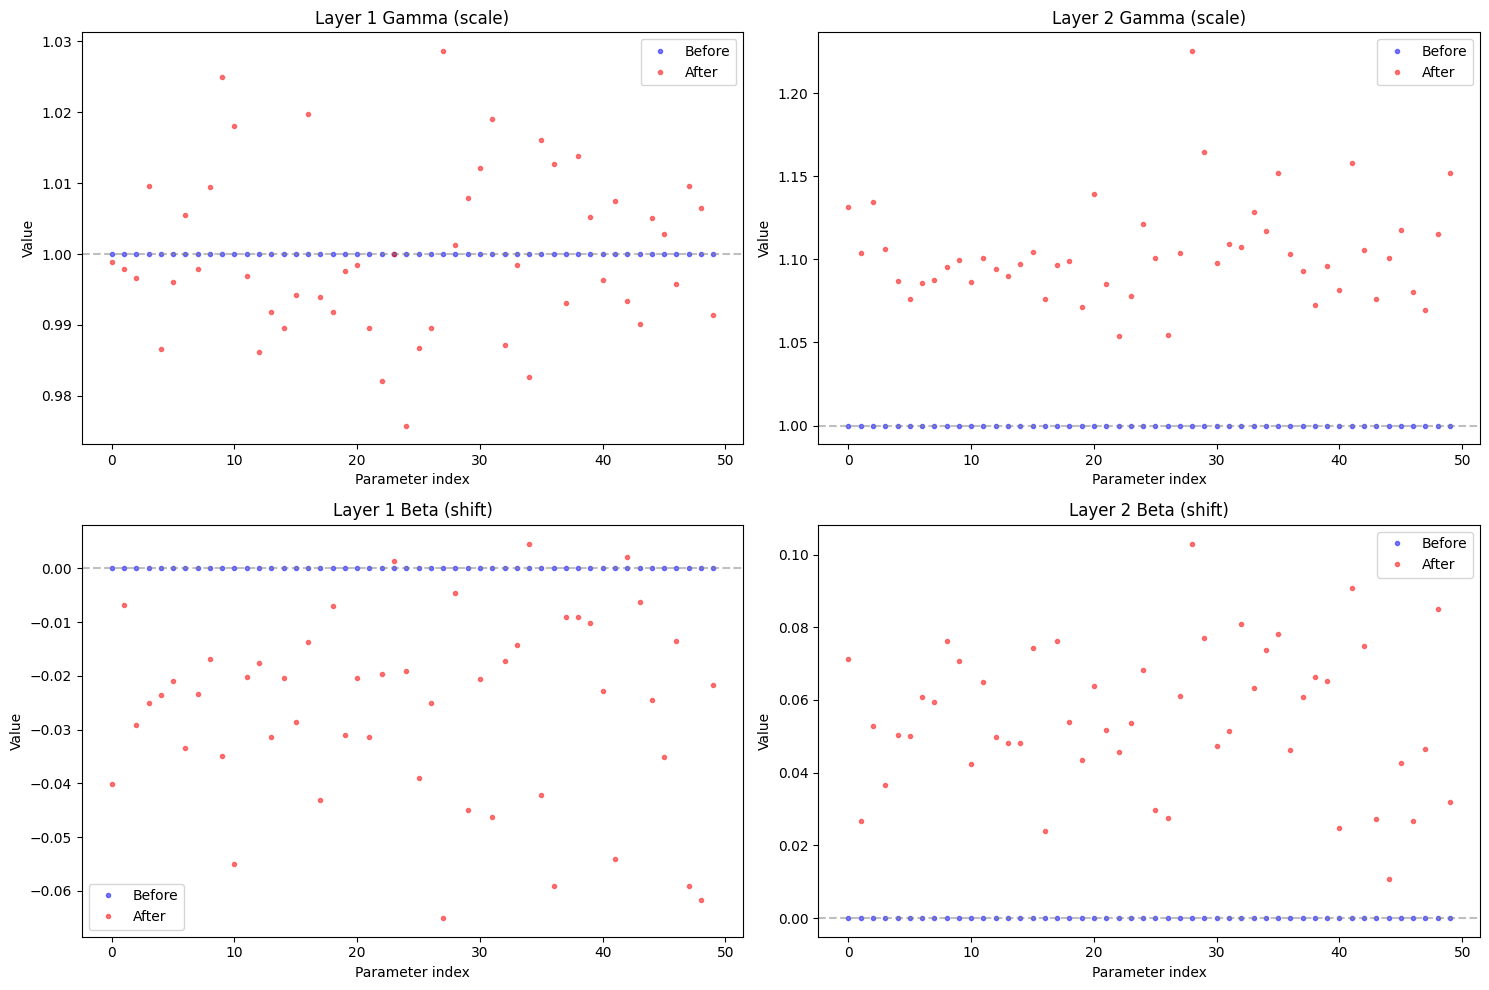

In [36]:
plt.figure(figsize=(15, 10))

# plot the first 50 elements of each layer for visibility
num_to_plot = 50

# plot gammas (scaling parameters)
for i, (before, after) in enumerate(zip(before_gammas, after_gammas)):
    plt.subplot(2, len(before_gammas), i+1)
    indices = np.arange(min(num_to_plot, len(before)))
    plt.plot(indices, before[:num_to_plot], 'b.', alpha=0.5, label='Before')
    plt.plot(indices, after[:num_to_plot], 'r.', alpha=0.5, label='After')
    plt.title(f'Layer {i+1} Gamma (scale)')
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)  # Initial value line
    plt.xlabel('Parameter index')
    plt.ylabel('Value')
    plt.legend()

# plot betas (shift parameters)
for i, (before, after) in enumerate(zip(before_betas, after_betas)):
    plt.subplot(2, len(before_betas), len(before_betas) + i+1)
    indices = np.arange(min(num_to_plot, len(before)))
    plt.plot(indices, before[:num_to_plot], 'b.', alpha=0.5, label='Before')
    plt.plot(indices, after[:num_to_plot], 'r.', alpha=0.5, label='After')
    plt.title(f'Layer {i+1} Beta (shift)')
    plt.axhline(y=0.0, color='gray', linestyle='--', alpha=0.5)  # Initial value line
    plt.xlabel('Parameter index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.savefig('batchnorm_parameters_improved.png')
plt.show()

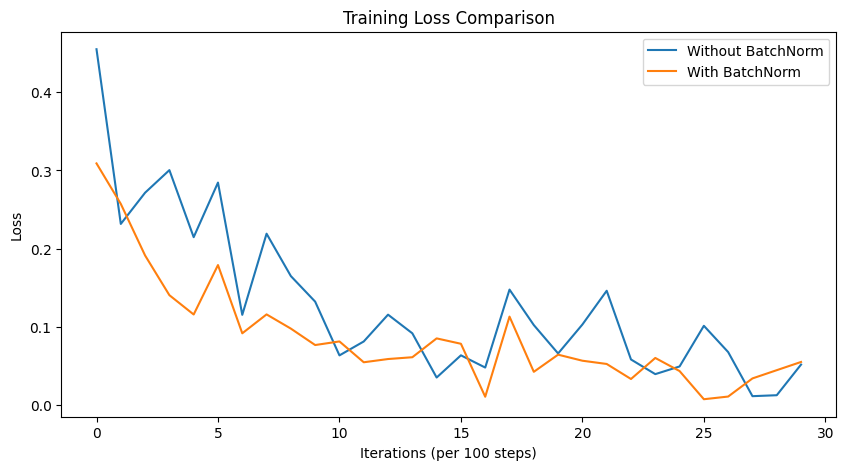

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(losses_without_bn, label='Without BatchNorm')
plt.plot(losses_with_bn, label='With BatchNorm')
plt.xlabel('Iterations (per 100 steps)')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.savefig('loss_comparison.png')
plt.show()

In [25]:
def visualize_activations(model, data_loader, with_bn=False):
    model.eval()
    activations = []
    
    # hook to capture activations
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu().numpy())
    
    # register the hook
    if with_bn:
        hook = model.bn1.register_forward_hook(hook_fn)
    else:
        hook = model.fc1.register_forward_hook(hook_fn)
    
    # get one batch of data
    images, _ = next(iter(data_loader))
    images = images.to(device)
    
    # forward pass
    _ = model(images)
    
    # remove the hook
    hook.remove()
    
    return activations[0]

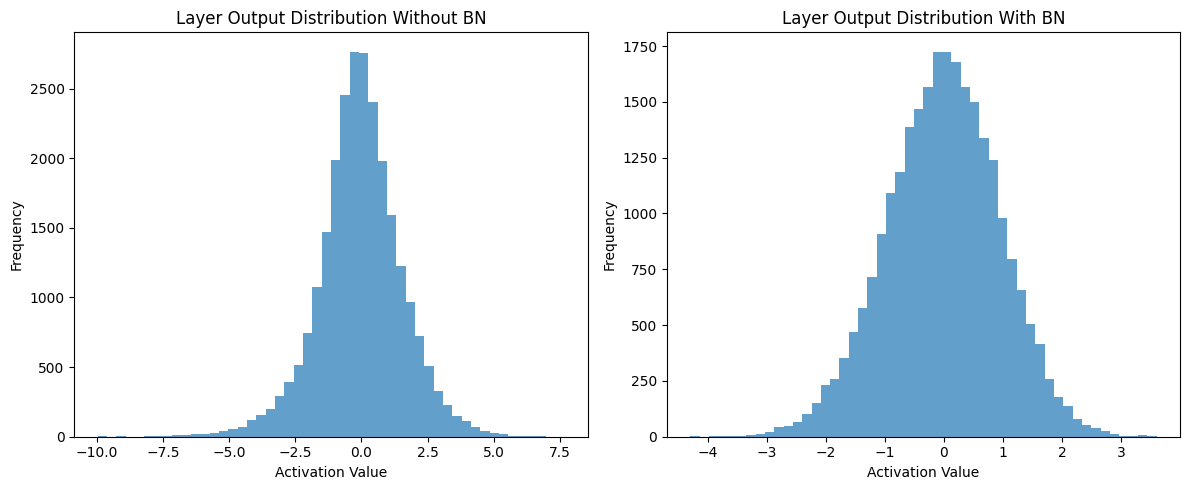

In [26]:
activations_without_bn = visualize_activations(model_without_bn, test_loader)
activations_with_bn = visualize_activations(model_with_bn, test_loader, with_bn=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(activations_without_bn.flatten(), bins=50, alpha=0.7)
plt.title('Layer Output Distribution Without BN')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(activations_with_bn.flatten(), bins=50, alpha=0.7)
plt.title('Layer Output Distribution With BN')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('activation_distribution.png')
plt.show()